In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-03-21 14:11:59.968227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-03-21 14:11:59.968319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-03-21 14:12:00.131545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Listing the image directories**

In [2]:
image_dir = 'covid-pneumonia-normal-chest-xray-images'

classes = os.listdir(image_dir)
print(classes)

['PNEUMONIA', 'NORMAL', 'COVID']


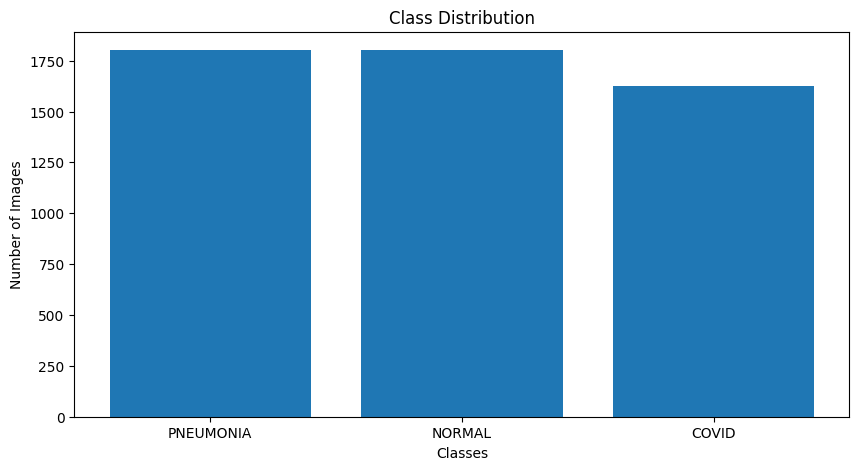

In [3]:
from collections import Counter

# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

**Printing sample images from each classes**

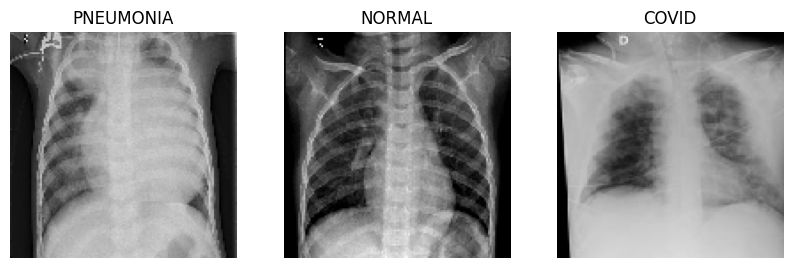

In [4]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


**Creating a Tensorflow dataset**

In [5]:
# Defining required variables
img_size = 256
batch_size = 32

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    labels='inferred',
    label_mode='int'
)

Found 5228 files belonging to 3 classes.


**Classes**

In [7]:
class_names = dataset.class_names
print(class_names)

['COVID', 'NORMAL', 'PNEUMONIA']


In [8]:
# Length of batches
len(dataset)

164

**Splitting above tf dataset**

In [9]:
# Let's define a function for train val test split
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [10]:
train_ds, val_ds, test_ds = split_dataset(dataset)

**Let's check the split**

In [11]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

131

16

17


**Optimize the data pipeline for training machine learning models**

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation**

In [13]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [14]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

**Let's define a CNN model**

In [15]:
model = Sequential()

# Apply resize_and_rescale and data augmentation
resize_and_rescale,
data_augmentation,

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(


In [16]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,515,011 (257.55 MB)

 Trainable params: 67,514,115 (257.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [18]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20



I0000 00:00:1711030390.958683      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

W0000 00:00:1711030390.978652      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8182 - loss: 2.0739

W0000 00:00:1711030438.140775      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 366ms/step - accuracy: 0.8186 - loss: 2.0695 - val_accuracy: 0.8821 - val_loss: 1.0251

Epoch 2/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.9390 - loss: 1.0270 - val_accuracy: 0.9634 - val_loss: 0.8162

Epoch 3/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9655 - loss: 0.8191 - val_accuracy: 0.9756 - val_loss: 0.7301

Epoch 4/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9697 - loss: 0.7333 - val_accuracy: 0.9858 - val_loss: 0.6296

Epoch 5/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9754 - loss: 0.6762 - val_accuracy: 0.9898 - val_loss: 0.6045

Epoch 6/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9780 - loss: 0.6370 - val_accuracy: 0.9898 - val_loss: 0.5711

Epoch 7/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9873 - loss: 0.5491 - val_accuracy: 0.9898 - val_loss: 0.5360

Epoch 8/20

131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9768 - loss

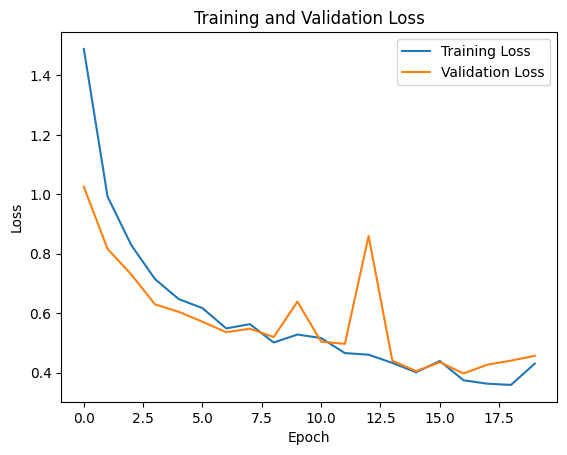

In [20]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

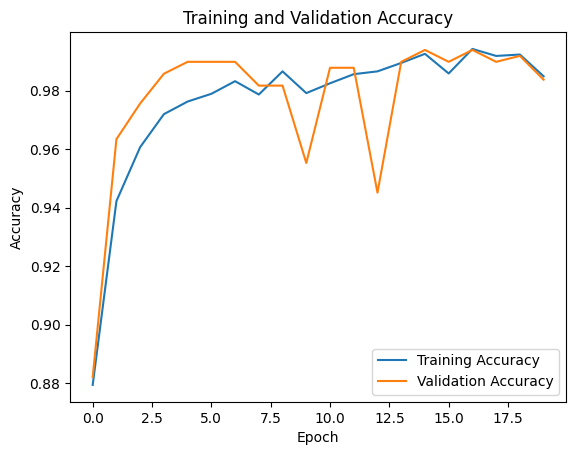

In [21]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

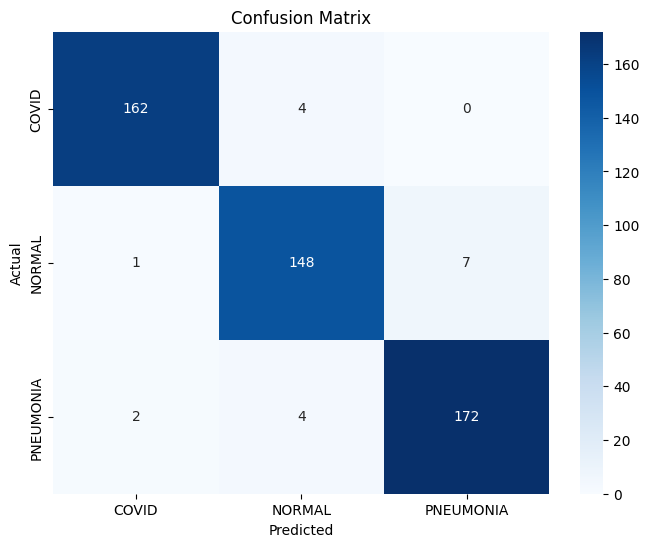

In [2]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=train_dataset.class_names, columns=train_dataset.class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.class_names)

# Print the report
print("\n--- Detailed Classification Report ---")
print(report)


    --- Detailed Classification Report ---
    
                 precision    recall  f1-score   support

    COVID           0.97      0.97      0.97       166
    NORMAL          0.95      0.95      0.95       156
    PNEUMONIA       0.96      0.97      0.96       178

    accuracy                            0.96       500
    macro avg       0.96      0.96      0.96       500
    weighted avg    0.96      0.96      0.96       500
    


[](http://)